In [170]:
from tractseg.data import dataset_specific_utils
from tractseg.libs.AFQ_MultiCompCorrection import AFQ_MultiCompCorrection
from tractseg.libs.AFQ_MultiCompCorrection import get_significant_areas
from tractseg.libs import metric_utils
from tractseg.libs import tracking
from tractseg.libs import tractometry
from dipy.tracking.utils import length

import os
import argparse
import math
from decimal import Decimal
from os.path import join

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats
import pandas as pd
from tqdm import tqdm

import glob as glob
import nibabel as nib
from scipy.stats import t as t_dist
from tractseg.libs import plot_utils
from sklearn.linear_model import LinearRegression

In [171]:
STUDY_PATH='/NAS/dumbo/protocoles/CogPhenoPark/'
IMAGES_DIR=STUDY_PATH+'TractSeg_output/'
TRACTO_DIR=STUDY_PATH+'TractSeg/'
FILE_PATH=os.path.join(STUDY_PATH,'liste_pts.csv')

In [172]:
def format_number(num):
    if abs(num) > 0.00001:
        return round(num, 4)
    else:
        return '%.2e' % Decimal(num)

50 distance_map FA CG_right
alphaFWE : 0.003593031660434785  clusterFWE : 9.0
Nb seg inf < 0.05 :  5.0


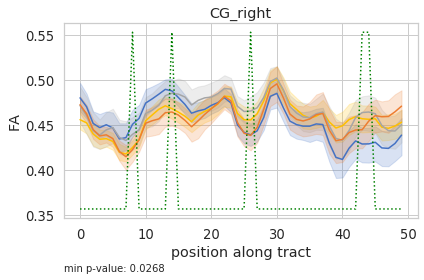

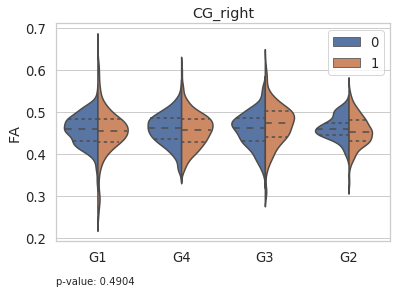

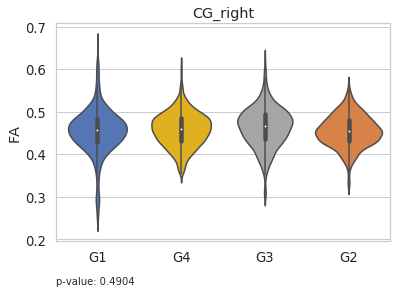

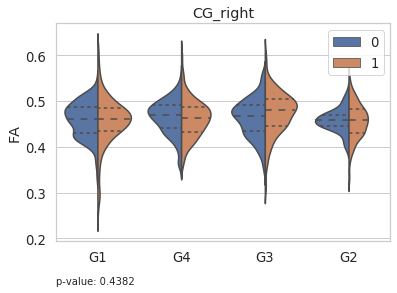

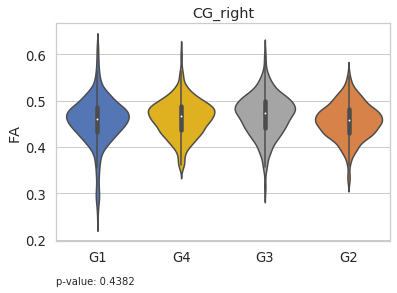

Nb seg inf < 0.05 :  5.0


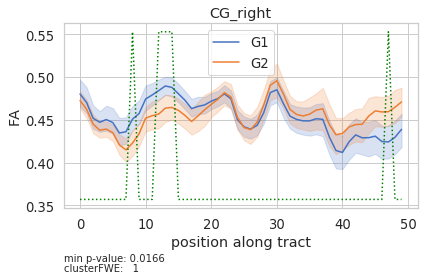

Nb seg inf < 0.05 :  7.0


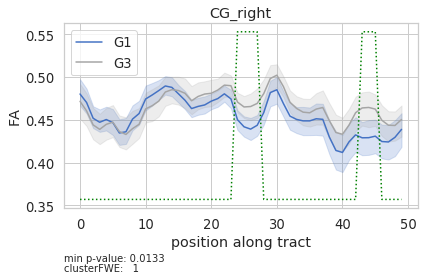

Nb seg inf < 0.05 :  2.0


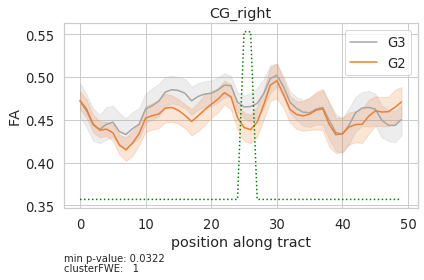

Nb seg inf < 0.05 :  11.0


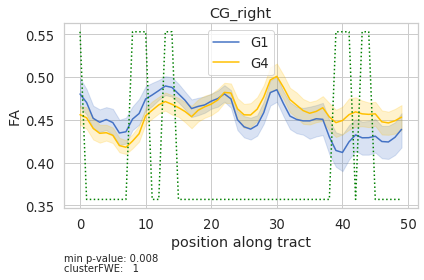

Nb seg inf < 0.05 :  0.0


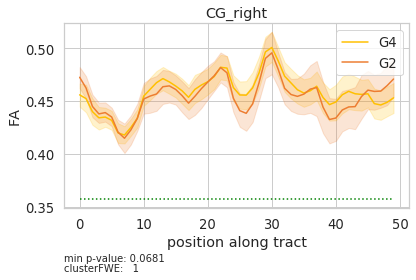

Nb seg inf < 0.05 :  0.0


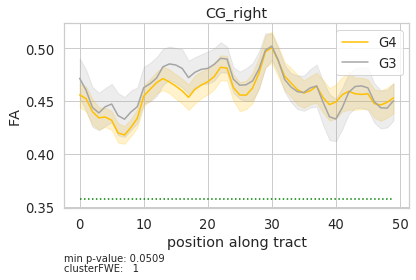

In [255]:
df = pd.read_csv(os.path.join(TRACTO_DIR,'Tractometry_template.txt'), sep=" ", comment="#")
df["subject_id"] = df["subject_id"].astype(str)

ColorTab = [(68/255,114/255,196/255,1),(237/255,125/255,49/255,1),(165/255,165/255,165/255,1),(255/255,192/255,0/255,1)]
ColorDic = {"G1":ColorTab[0],"G2":ColorTab[1],"G3":ColorTab[2],"G4":ColorTab[3]}
for NR_POINTS in ([50]):#([60,70,80,100]):
    for ALGORITHM in (['''distance_map''']):#(['''equal_dist''','''distance_map''','''cutting_plane''','''afq''']):
        for PARA in (['''FA''']):#(['''FA''','''MD''']): 
            for BUNDLE in (['''CG_right''']):#(['''ST_PREF_right''','''CC_2''','''ST_FO_right''','''CC_1''','''T_PREF_right''','''CG_right''','''FPT_right''']):    
                print(NR_POINTS,ALGORITHM,PARA,BUNDLE)
                if os.path.exists(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+'.npy')) :
                    npvalues=np.load(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+'.npy'))
                else :  
                    npvalues = np.zeros([len(df),NR_POINTS])
                    for idx, jdx in df.iterrows():
                        SUBJ=df.iloc[idx]['subject_id'] # df.subject_id[0] ou encore jdx['subject_id']
                        #print(SUBJ)
                        TRACTO_TCK=os.path.join(TRACTO_DIR,SUBJ,'CT_'+BUNDLE+'_track.tck')
                        SCALAR_IMG=os.path.join(TRACTO_DIR,SUBJ,'fit_'+PARA+'.nii.gz')
                        START_IMG=os.path.join(TRACTO_DIR,SUBJ,'CT_ROI_'+SUBJ+'.nii.gz')
                        scalar_image = nib.load(SCALAR_IMG)
                        beginnings = nib.load(START_IMG)
                        sl_file = nib.streamlines.load(TRACTO_TCK)
                        streamlines = sl_file.streamlines
                        val=list(length(streamlines))
                        #print(np.mean(val),np.std(val))
                        if len(streamlines) > 5 :
                            mean, std = tractometry.evaluate_along_streamlines(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=2,predicted_peaks=None, affine=scalar_image.affine)
                            npvalues[idx, :] = mean[1:-1]
                    np.save(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)),npvalues)
                
                ###########
                #regression des covariables
                ###########                    
                confound=df[list(df.columns[1:])].values
                lr = LinearRegression(fit_intercept=True).fit(confound,npvalues) 
                y_predicted_by_confound = lr.coef_[:, 1:] @ confound[:, 1:].T
                # Pour regresser sans les groupes : y_predicted_by_confound = lr.coef_ @ confound.T  # [targets, samples]
                npvalues_corrected = npvalues - y_predicted_by_confound.T

                #Bring data into right format for seaborn
                data = {"position": [],
                        "metric": [],
                        "group": [],
                        "subject": [],
                        "sex": []}

                for idx, jdx in df.iterrows():
                    SUBJ=df.iloc[idx]['subject_id'] 
                    GROUP=df.iloc[idx]['group']                     
                    SEX=df.iloc[idx]['sex']
                    for position in range(NR_POINTS):
                        data["position"].append(position)
                        data["subject"].append(SUBJ)
                        data["metric"].append(npvalues_corrected[idx][position])
                        data["group"].append('G'+str(GROUP+1))
                        data["sex"].append(SEX)

                pvalues = np.zeros(NR_POINTS)
                stats = np.zeros(NR_POINTS)  # for ttest: t-value, for pearson: correlation
                stats, pvalues=scipy.stats.f_oneway(npvalues_corrected[df[df['group']==0].index,:], npvalues_corrected[df[df['group']==1].index,:], npvalues_corrected[df[df['group']==2].index,:], npvalues_corrected[df[df['group']==3].index,:])

                alpha=0.05
                nperm=5000
                alphaFWE, statFWE, clusterFWE, stats = AFQ_MultiCompCorrection(npvalues_corrected,df['group'].values,alpha, nperm=nperm)
                print('alphaFWE :',alphaFWE,' clusterFWE :',clusterFWE)
                pvalues_tmp=1-pvalues
                pvalues_tmp[pvalues_tmp>0.95]=1
                pvalues_tmp[pvalues_tmp<=0.95]=0
                print("Nb seg inf < 0.05 : ",np.sum(pvalues_tmp))
                
                #clusterFWE=NR_POINTS/10-1
                #alphaFWE=0.05
                #print('alphaFWE :',alphaFWE,' clusterFWE :',clusterFWE)   
                
                sns.set(font_scale=1.2)
                sns.set_style("whitegrid")
                %matplotlib inline
                #palette = sns.color_palette("mako_r", 6)
                #color="coral"
                #sns.set_palette("husl")
                #dataTest = pd.Series(result_prices)
                #penses betes palette=['0.3','0.3','0.6','0.3'] pour n
                #ax = sns.lineplot(x="position", y="metric", palette=[ColorTab[0],ColorTab[1],ColorTab[2],ColorTab[3]],data=data,hue="group")
                ax = sns.lineplot(x="position", y="metric", palette=ColorDic,data=data,hue="group")
                ax.set(xlabel='position along tract', ylabel=PARA)
                ax.set_title(BUNDLE)
                ax.legend_.remove()         

                #sig_areas = get_significant_areas(pvalues, 1, alphaFWE)
                #sig_areas = sig_areas * np.quantile(np.array(data["metric"]), 0.98)
                #sig_areas[sig_areas == 0] = np.quantile(np.array(data["metric"]), 0.02)
                #ax.plot(range(len(sig_areas)), sig_areas, color="red", linestyle="-")
                clusterFWE=1
                sig_areas2 = get_significant_areas(pvalues, clusterFWE, alpha)
                sig_areas2 = sig_areas2 * np.quantile(np.array(data["metric"]), 0.98)
                sig_areas2[sig_areas2 == 0] = np.quantile(np.array(data["metric"]), 0.02)
                ax.plot(range(len(sig_areas2)), sig_areas2, color="green", linestyle=":")
                
               # ax.annotate("alphaFWE:   {}".format(format_number(alphaFWE)),
               #                  (0, 0), (0, -65), xycoords='axes fraction', textcoords='offset points', va='top',
               #                  fontsize=10)
                ax.annotate("min p-value: {}".format(format_number(pvalues.min())),
                                 (0, 0), (0, -45), xycoords='axes fraction', textcoords='offset points', va='top',
                                 fontsize=10)
               # ax.annotate("clusterFWE:   {}".format(clusterFWE),
               #                  (0, 0), (0, -55), xycoords='axes fraction', textcoords='offset points', va='top',
               #                  fontsize=10)

                plt.tight_layout()
                plt.savefig(os.path.join(STUDY_PATH,"screenshots","ANOVA_PROFILE_"+PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+"_wcofound_clusterandfwe.png"), dpi=300)
                plt.show()
                plt.close()
                
                #########
                #Les boxplots (ou violinplots) sur le fx entiers
                #########
                stat_val,p_val=scipy.stats.f_oneway(np.mean(npvalues_corrected[df[df['group']==0].index,:],axis=1),np.mean(npvalues_corrected[df[df['group']==1].index,:],axis=1),np.mean(npvalues_corrected[df[df['group']==2].index,:],axis=1),np.mean(npvalues_corrected[df[df['group']==3].index,:],axis=1))

                ax = sns.violinplot(x="group", y="metric", data=data,hue="sex",split=True,inner="quartile")
                ax.set(ylabel=PARA)
                ax.set_title(BUNDLE)
                ax.annotate("p-value: {}".format(format_number(p_val)),
                                 (0, 0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top',
                                 fontsize=10)
                plt.savefig(os.path.join(STUDY_PATH,"screenshots","ANOVA_VIOLINPLOT_FULL_V1_"+PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+"_wcofound_clusterandfwe.png"), dpi=300)
                plt.show()
                
                #ax = sns.violinplot(x="group", y="metric", data=data, palette=[ColorTab[0],ColorTab[1],ColorTab[2],ColorTab[3]])
                ax = sns.violinplot(x="group", y="metric", data=data, palette=ColorDic)
                ax.set(ylabel=PARA)
                ax.set_title(BUNDLE)
                ax.annotate("p-value: {}".format(format_number(p_val)),
                                 (0, 0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top',
                                 fontsize=10)
                plt.savefig(os.path.join(STUDY_PATH,"screenshots","ANOVA_VIOLINPLOT_FULL_V2_"+PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+"_wcofound_clusterandfwe.png"), dpi=300)
                plt.show()
                
                #########
                #Les boxplots (ou violinplots) sur la partie significative
                #########
                if (np.sum(get_significant_areas(pvalues, clusterFWE, alpha))>0) :
                    start=np.min(np.where(get_significant_areas(pvalues, clusterFWE, alpha)==1))
                    stop=np.max(np.where(get_significant_areas(pvalues, clusterFWE, alpha)==1))

                    dataSIGN = {"position": [],
                        "metric": [],
                        "group": [],
                        "subject": [],
                        "sex": []}

                    for idx, jdx in df.iterrows():
                        SUBJ=df.iloc[idx]['subject_id'] 
                        GROUP=df.iloc[idx]['group']                     
                        SEX=df.iloc[idx]['sex']
                        for position in range(start,stop+1):
                            dataSIGN["position"].append(position)
                            dataSIGN["subject"].append(SUBJ)
                            dataSIGN["metric"].append(npvalues_corrected[idx][position])
                            dataSIGN["group"].append('G'+str(GROUP+1))
                            dataSIGN["sex"].append(SEX)

                    stat_val,p_val=scipy.stats.f_oneway(np.mean(npvalues_corrected[df[df['group']==0].index,start:stop],axis=1),np.mean(npvalues_corrected[df[df['group']==1].index,start:stop],axis=1),np.mean(npvalues_corrected[df[df['group']==2].index,start:stop],axis=1),np.mean(npvalues_corrected[df[df['group']==3].index,start:stop],axis=1))

                    ax = sns.violinplot(x="group", y="metric", data=dataSIGN,hue="sex",split=True,inner="quartile")
                    ax.set(ylabel=PARA)
                    ax.set_title(BUNDLE)
                    ax.annotate("p-value: {}".format(format_number(p_val)),
                                     (0, 0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top',
                                     fontsize=10)
                    plt.savefig(os.path.join(STUDY_PATH,"screenshots","ANOVA_VIOLINPLOT_SIGN_V1_"+PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+"_wcofound_clusterandfwe.png"), dpi=300)
                    plt.show()

                    #ax = sns.violinplot(x="group", y="metric", data=dataSIGN, palette=[ColorTab[0],ColorTab[1],ColorTab[2],ColorTab[3]])
                    ax = sns.violinplot(x="group", y="metric", data=dataSIGN, palette=ColorDic)
                    ax.set(ylabel=PARA)
                    ax.set_title(BUNDLE)
                    ax.annotate("p-value: {}".format(format_number(p_val)),
                                     (0, 0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top',
                                     fontsize=10)
                    plt.savefig(os.path.join(STUDY_PATH,"screenshots","ANOVA_VIOLINPLOT_SIGN_V2_"+PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+"_wcofound_clusterandfwe.png"), dpi=300)
                    plt.show()

                #######
                #TTest sur les profils
                ######  
                if (np.any(pvalues<0.05)):
                    for g2 in range(4):
                        for g1 in range(g2):
                            filter1=df['group']==g1
                            filter2=df['group']==g2
                            subdf=df.where(filter1|filter2,inplace=False)
                            subdf=subdf.dropna()

                            dataTTest = {"position": [],
                                    "metric": [],
                                    "group": [],
                                    "subject": [],
                                    "sex": []}

                            for idx, jdx in subdf.iterrows():
                                SUBJ=df.iloc[idx]['subject_id'] 
                                GROUP=df.iloc[idx]['group']                     
                                SEX=df.iloc[idx]['sex']
                                for position in range(NR_POINTS):
                                    dataTTest["position"].append(position)
                                    dataTTest["subject"].append(SUBJ)
                                    dataTTest["metric"].append(npvalues_corrected[idx][position])
                                    dataTTest["group"].append('G'+str(GROUP+1))
                                    dataTTest["sex"].append(SEX)

                            alphaFWE, statFWE, clusterFWE, stats = AFQ_MultiCompCorrection(npvalues_corrected[subdf.index,:],subdf['group'].values,alpha, nperm=nperm)             

                            stats, pvalues = scipy.stats.ttest_ind(npvalues_corrected[df[df['group']==g1].index,:], npvalues_corrected[df[df['group']==g2].index,:])
                            #ax = sns.lineplot(x="position", y="metric", palette=[ColorTab[g1],ColorTab[g2]],data=dataTTest,hue="group")
                            ax = sns.lineplot(x="position", y="metric", palette=ColorDic,data=dataTTest,hue="group")
                            ax.set(xlabel='position along tract', ylabel=PARA)
                            ax.set_title(BUNDLE)

                            pvalues_tmp=1-pvalues
                            pvalues_tmp[pvalues_tmp>0.95]=1
                            pvalues_tmp[pvalues_tmp<=0.95]=0

                            print("Nb seg inf < 0.05 : ",np.sum(pvalues_tmp))
                            clusterFWE=1
                            sig_areas2 = get_significant_areas(pvalues, clusterFWE, alpha)
                            sig_areas2 = sig_areas2 * np.quantile(np.array(data["metric"]), 0.98)
                            sig_areas2[sig_areas2 == 0] = np.quantile(np.array(data["metric"]), 0.02)
                            ax.plot(range(len(sig_areas2)), sig_areas2, color="green", linestyle=":")

                            #sig_areas = get_significant_areas(pvalues, 1, alphaFWE)
                            #sig_areas = sig_areas * np.quantile(np.array(data["metric"]), 0.98)
                            #sig_areas[sig_areas == 0] = np.quantile(np.array(data["metric"]), 0.02)
                            #ax.plot(range(len(sig_areas)), sig_areas, color="red", linestyle="-")

                            #ax.annotate("alphaFWE:   {}".format(format_number(alphaFWE)),
                            #                 (0, 0), (0, -65), xycoords='axes fraction', textcoords='offset points', va='top',
                            #                 fontsize=10)
                            ax.annotate("min p-value: {}".format(format_number(pvalues.min())),
                                             (0, 0), (0, -45), xycoords='axes fraction', textcoords='offset points', va='top',
                                             fontsize=10)
                            ax.annotate("clusterFWE:   {}".format(clusterFWE),
                                             (0, 0), (0, -55), xycoords='axes fraction', textcoords='offset points', va='top',
                                             fontsize=10)

                            plt.tight_layout()
                            plt.savefig(os.path.join(STUDY_PATH,"screenshots","TTEST_PROFILE_G"+str(g1+1)+"_G"+str(g2+1)+"_"+PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+"_wcofound_clusterandfwe.png"), dpi=300)
                            plt.show()
                            plt.close()

In [251]:
#stat_val,p_val=scipy.stats.f_oneway(np.mean(npvalues_corrected[df[df['group']==0].index,:],axis=1),np.mean(npvalues_corrected[df[df['group']==1].index,:],axis=1),np.mean(npvalues_corrected[df[df['group']==2].index,:],axis=1),np.mean(npvalues_corrected[df[df['group']==3].index,:],axis=1))
#np.mean(npvalues_corrected[df[df['group']==0].index,:],axis=1)
print(df[df['group']==0].subject_id)
np.savetxt(os.path.join(TRACTO_DIR,'FA_SIGN_SEGMENT_GROUP0.txt'),np.mean(npvalues_corrected[df[df['group']==0].index,start:stop],axis=1))
print(df[df['group']==1].subject_id)
np.savetxt(os.path.join(TRACTO_DIR,'FA_SIGN_SEGMENT_GROUP1.txt'),np.mean(npvalues_corrected[df[df['group']==1].index,start:stop],axis=1))
print(df[df['group']==2].subject_id)
np.savetxt(os.path.join(TRACTO_DIR,'FA_SIGN_SEGMENT_GROUP2.txt'),np.mean(npvalues_corrected[df[df['group']==2].index,start:stop],axis=1))
print(df[df['group']==3].subject_id)
np.savetxt(os.path.join(TRACTO_DIR,'FA_SIGN_SEGMENT_GROUP3.txt'),np.mean(npvalues_corrected[df[df['group']==3].index,start:stop:],axis=1))

0                 T84028
64        380304JM130613
65        491029AS010813
66        460829CC090913
67        501204YV100913
68       490128JBD171013
69        590305CF211113
70        501218DB251113
71        420901MW051213
72        430702JG100214
73        500425EF100314
74        100269SD100714
75                T84003
76                T84005
77                T84012
78                T84014
79                T84015
80                T84022
81                T84023
82                T84026
83                T84030
84                T84031
85                T84032
86                T84036
87                T84040
88                T84044
89                T84047
90                T84052
91                T84053
92                T84057
93                T84058
94                T84063
95                T84064
96                T84065
97                T84066
98                T84075
99                T84076
105               T84029
106    530802JV130114_PB
Name: subject_id, dtype: 

50 distance_map FA ST_PREF_right
alphaFWE : 0.0035742452141791677  clusterFWE : 10.0
Nb seg inf < 0.05 :  6.0


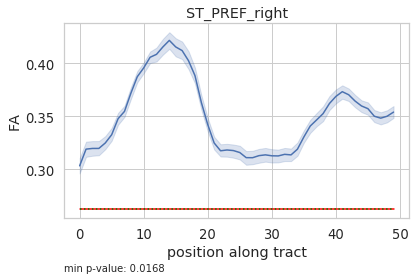

50 distance_map FA CC_2
alphaFWE : 0.0026279360325334924  clusterFWE : 8.0
Nb seg inf < 0.05 :  5.0


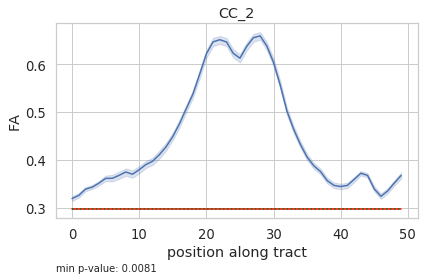

50 distance_map FA ST_FO_right
alphaFWE : 0.013132999215328586  clusterFWE : 15.0
Nb seg inf < 0.05 :  0.0


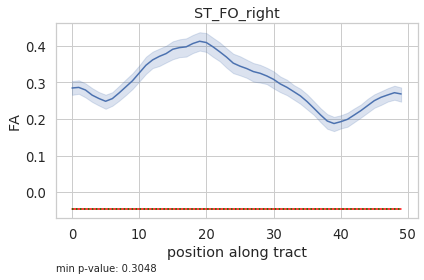

50 distance_map FA CC_1
alphaFWE : 0.011734859671137767  clusterFWE : 12.0
Nb seg inf < 0.05 :  0.0


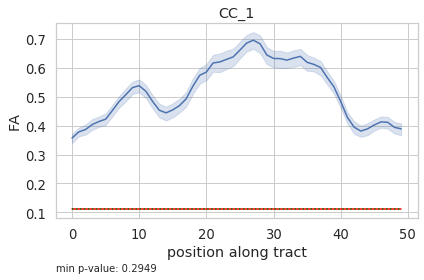

50 distance_map FA T_PREF_right
alphaFWE : 0.002567218364349356  clusterFWE : 8.0
Nb seg inf < 0.05 :  3.0


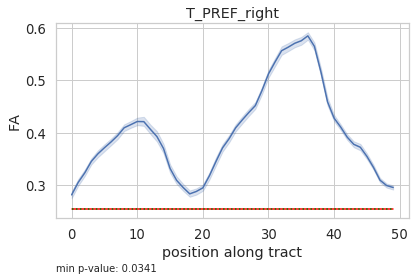

50 distance_map FA CG_right
alphaFWE : 0.0035695947584449173  clusterFWE : 9.0
Nb seg inf < 0.05 :  6.0


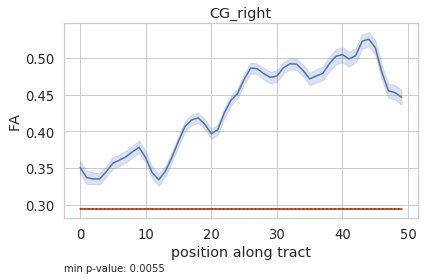

50 distance_map FA FPT_right
alphaFWE : 0.006614812810597705  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


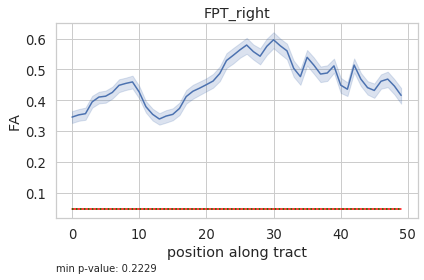

50 distance_map MD ST_PREF_right
alphaFWE : 0.00548639026023589  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


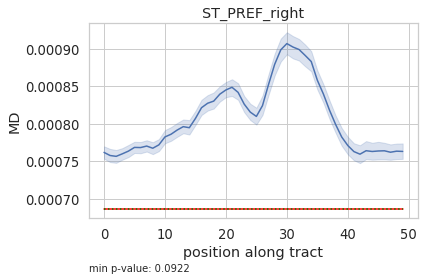

50 distance_map MD CC_2
alphaFWE : 0.004308884303526412  clusterFWE : 12.0
Nb seg inf < 0.05 :  0.0


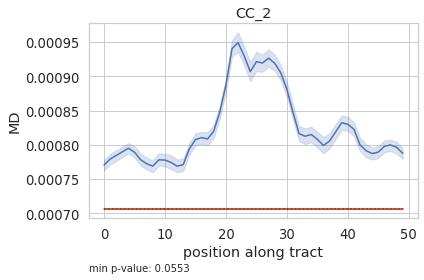

50 distance_map MD ST_FO_right
alphaFWE : 0.02380346797989655  clusterFWE : 16.0
Nb seg inf < 0.05 :  0.0


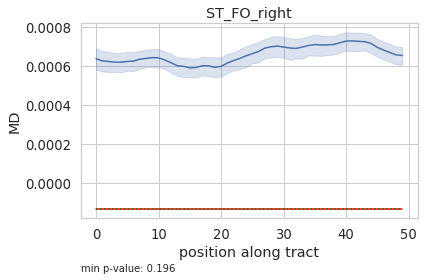

50 distance_map MD CC_1
alphaFWE : 0.018080448640824722  clusterFWE : 14.0
Nb seg inf < 0.05 :  0.0


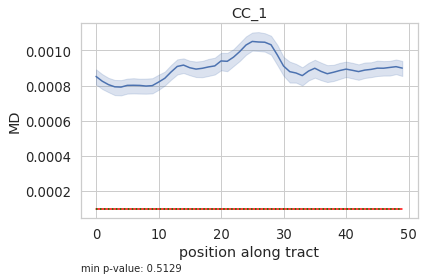

50 distance_map MD T_PREF_right
alphaFWE : 0.004375613086893449  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


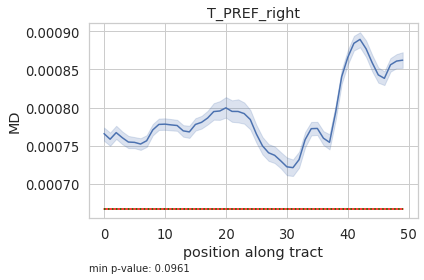

50 distance_map MD CG_right
alphaFWE : 0.004343588178502996  clusterFWE : 9.0
Nb seg inf < 0.05 :  0.0


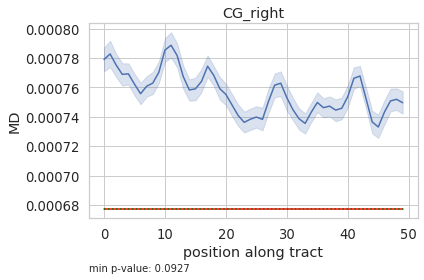

50 distance_map MD FPT_right
alphaFWE : 0.01187952962281038  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


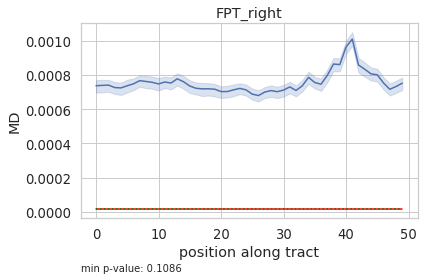

50 distance_map FA ST_PREF_right
alphaFWE : 0.00366091626974191  clusterFWE : 10.0
Nb seg inf < 0.05 :  6.0


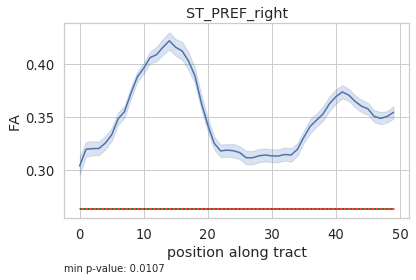

50 distance_map FA CC_2
alphaFWE : 0.0023901886328016094  clusterFWE : 8.0
Nb seg inf < 0.05 :  1.0


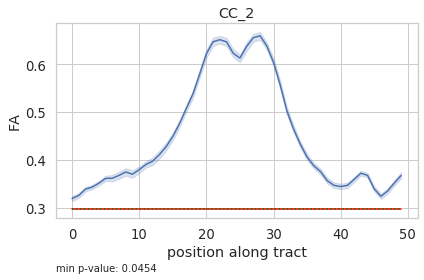

50 distance_map FA ST_FO_right
alphaFWE : 0.014068546141103953  clusterFWE : 15.0
Nb seg inf < 0.05 :  0.0


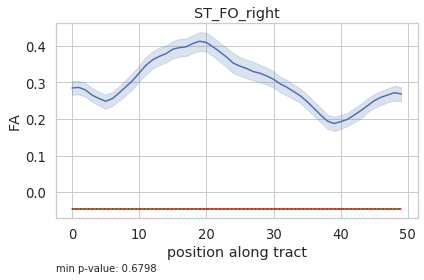

50 distance_map FA CC_1
alphaFWE : 0.01312508409975128  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


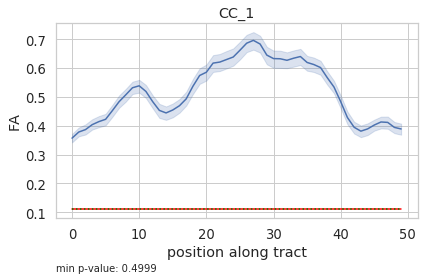

50 distance_map FA T_PREF_right
alphaFWE : 0.002851098639894919  clusterFWE : 8.0
Nb seg inf < 0.05 :  4.0


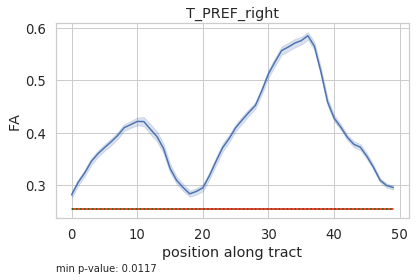

50 distance_map FA CG_right
alphaFWE : 0.00401654163536038  clusterFWE : 9.0
Nb seg inf < 0.05 :  14.0


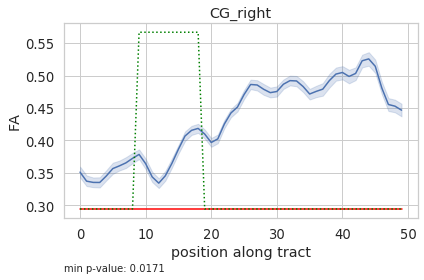

50 distance_map FA FPT_right
alphaFWE : 0.006918531545231756  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


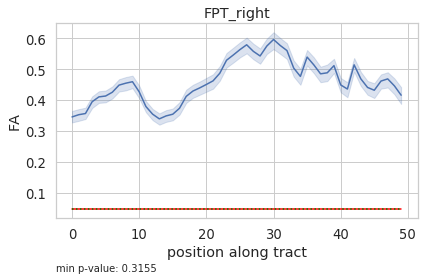

50 distance_map MD ST_PREF_right
alphaFWE : 0.004922255686860015  clusterFWE : 14.0
Nb seg inf < 0.05 :  0.0


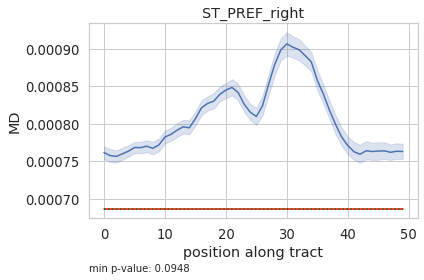

50 distance_map MD CC_2
alphaFWE : 0.004746821332053379  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


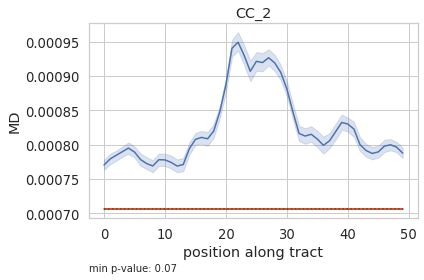

50 distance_map MD ST_FO_right
alphaFWE : 0.021675231167642906  clusterFWE : 16.0
Nb seg inf < 0.05 :  0.0


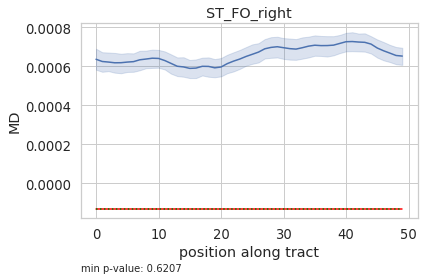

50 distance_map MD CC_1
alphaFWE : 0.018401466809429456  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


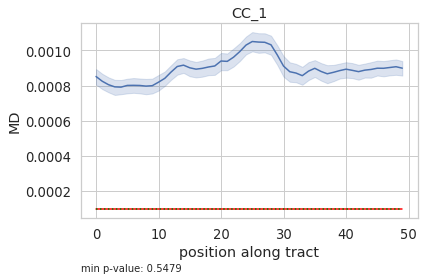

50 distance_map MD T_PREF_right
alphaFWE : 0.0036871472144550995  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


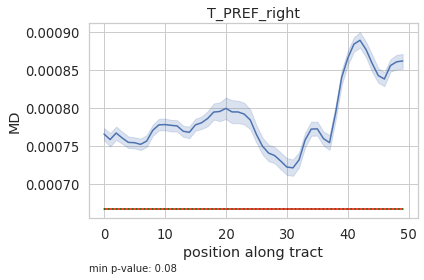

50 distance_map MD CG_right
alphaFWE : 0.004524600647123429  clusterFWE : 9.0
Nb seg inf < 0.05 :  0.0


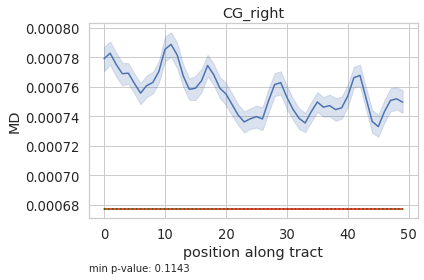

50 distance_map MD FPT_right
alphaFWE : 0.01258606797506464  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


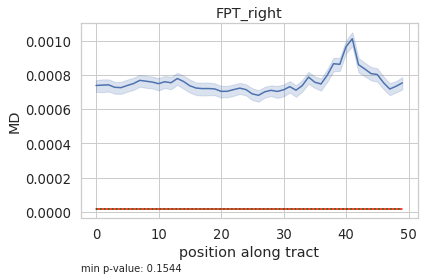

50 distance_map FA ST_PREF_right
alphaFWE : 0.003453123106622366  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


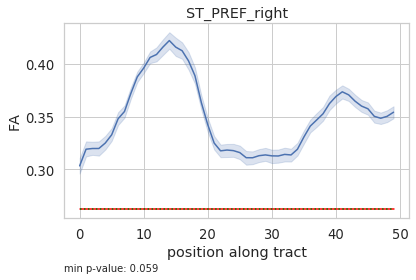

50 distance_map FA CC_2
alphaFWE : 0.002719651549237154  clusterFWE : 8.0
Nb seg inf < 0.05 :  0.0


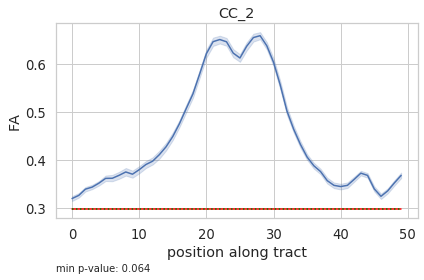

50 distance_map FA ST_FO_right
alphaFWE : 0.012438498323619242  clusterFWE : 15.0
Nb seg inf < 0.05 :  0.0


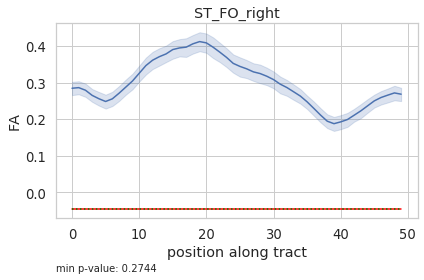

50 distance_map FA CC_1
alphaFWE : 0.011919096774860777  clusterFWE : 12.0
Nb seg inf < 0.05 :  0.0


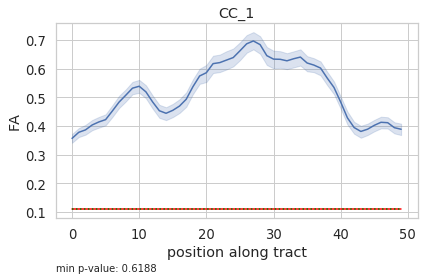

50 distance_map FA T_PREF_right
alphaFWE : 0.00246749697030319  clusterFWE : 8.0
Nb seg inf < 0.05 :  0.0


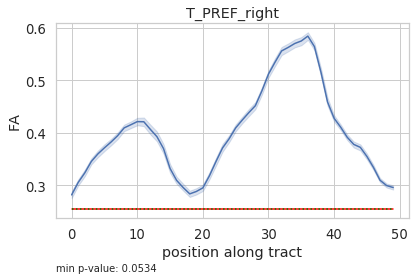

50 distance_map FA CG_right
alphaFWE : 0.00353919357534611  clusterFWE : 9.0
Nb seg inf < 0.05 :  4.0


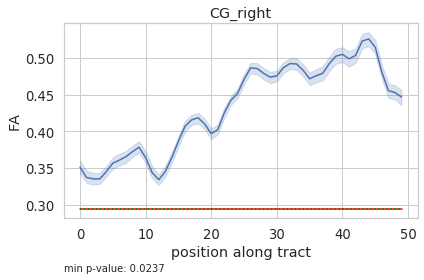

50 distance_map FA FPT_right
alphaFWE : 0.006642330968436204  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


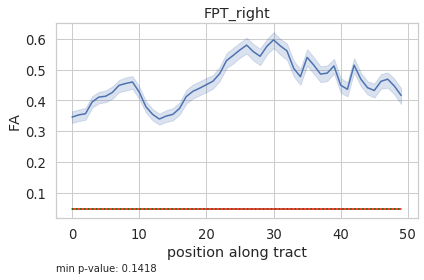

50 distance_map MD ST_PREF_right
alphaFWE : 0.00618284665013996  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


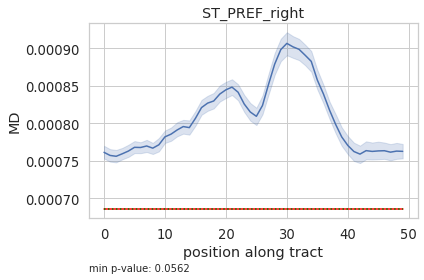

50 distance_map MD CC_2
alphaFWE : 0.004735163434573527  clusterFWE : 11.0
Nb seg inf < 0.05 :  8.0


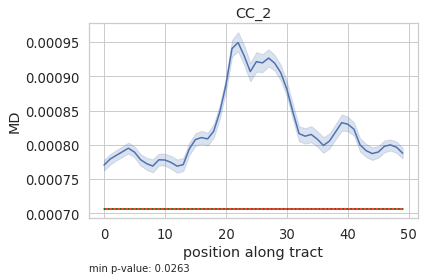

50 distance_map MD ST_FO_right
alphaFWE : 0.025878060429726426  clusterFWE : 12.0
Nb seg inf < 0.05 :  0.0


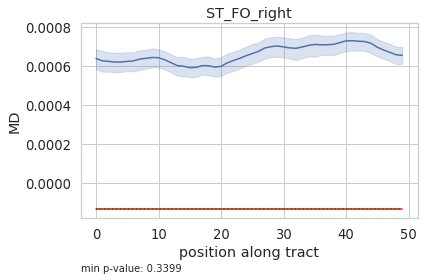

50 distance_map MD CC_1
alphaFWE : 0.020263404408746927  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


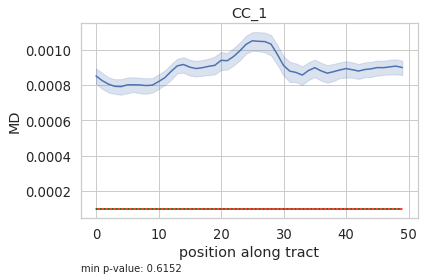

50 distance_map MD T_PREF_right
alphaFWE : 0.004008701689420905  clusterFWE : 11.0
Nb seg inf < 0.05 :  2.0


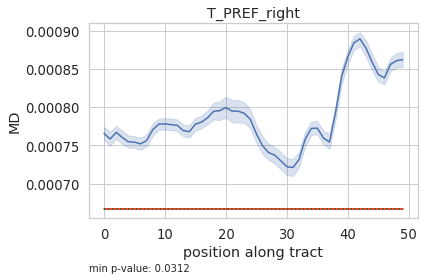

50 distance_map MD CG_right
alphaFWE : 0.004412810835541322  clusterFWE : 9.0
Nb seg inf < 0.05 :  7.0


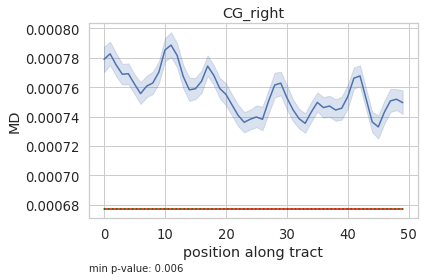

50 distance_map MD FPT_right
alphaFWE : 0.012460252862044602  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


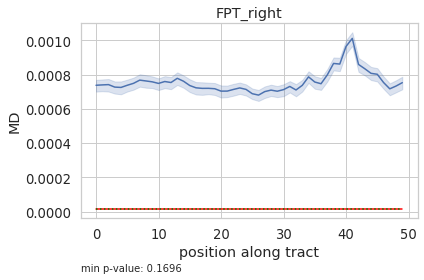

50 distance_map FA ST_PREF_right
alphaFWE : 0.0037468631891057614  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


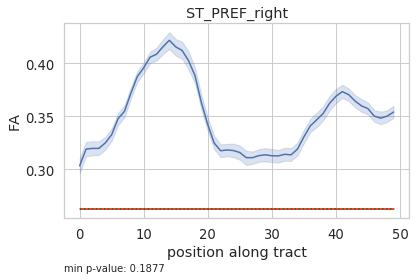

50 distance_map FA CC_2
alphaFWE : 0.0027931640343658993  clusterFWE : 8.0
Nb seg inf < 0.05 :  0.0


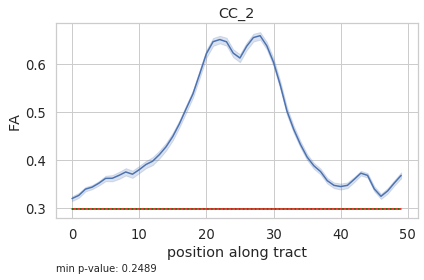

50 distance_map FA ST_FO_right
alphaFWE : 0.014193131245729093  clusterFWE : 14.0
Nb seg inf < 0.05 :  0.0


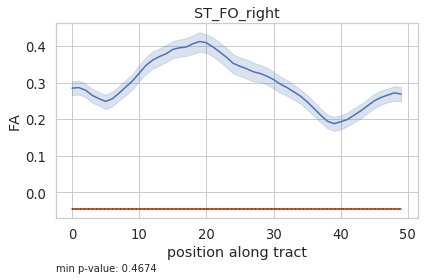

50 distance_map FA CC_1
alphaFWE : 0.011561859263251142  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


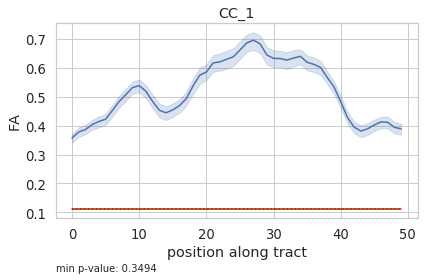

50 distance_map FA T_PREF_right
alphaFWE : 0.0023095911455743483  clusterFWE : 8.0
Nb seg inf < 0.05 :  0.0


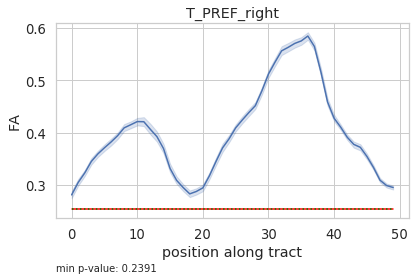

50 distance_map FA CG_right
alphaFWE : 0.0039025718652244573  clusterFWE : 9.0
Nb seg inf < 0.05 :  0.0


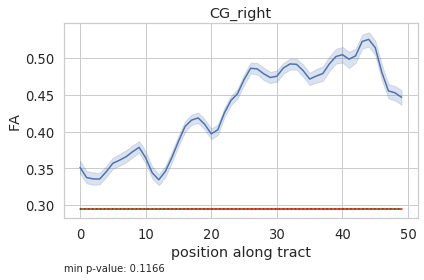

50 distance_map FA FPT_right
alphaFWE : 0.00670575037289698  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


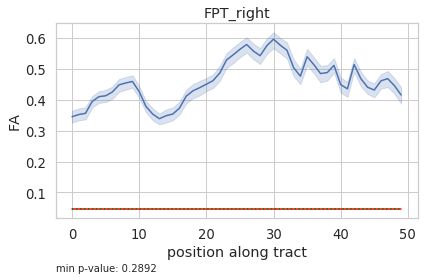

50 distance_map MD ST_PREF_right
alphaFWE : 0.005535276688721607  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


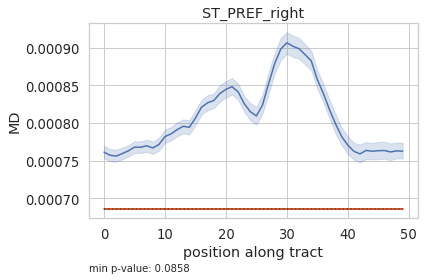

50 distance_map MD CC_2
alphaFWE : 0.004743061147885238  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


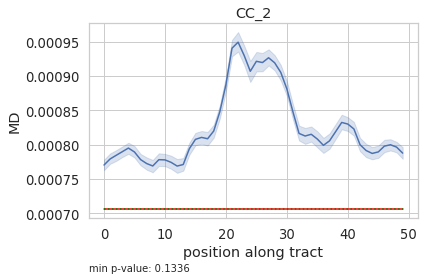

50 distance_map MD ST_FO_right
alphaFWE : 0.020378761289340575  clusterFWE : 16.0
Nb seg inf < 0.05 :  0.0


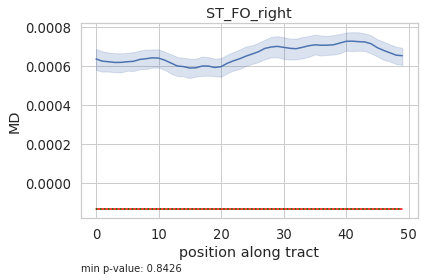

50 distance_map MD CC_1
alphaFWE : 0.019070538523545438  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


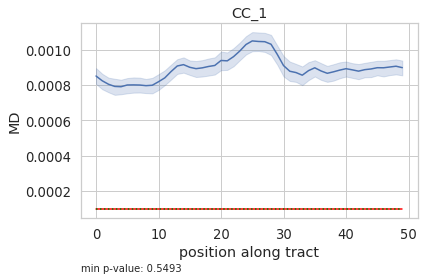

50 distance_map MD T_PREF_right
alphaFWE : 0.004278945030008399  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


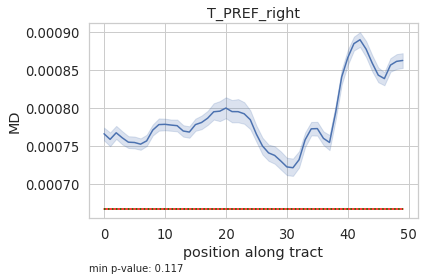

50 distance_map MD CG_right
alphaFWE : 0.004801357990998901  clusterFWE : 9.0
Nb seg inf < 0.05 :  4.0


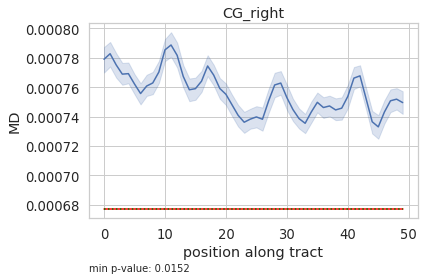

50 distance_map MD FPT_right
alphaFWE : 0.012115091255664328  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


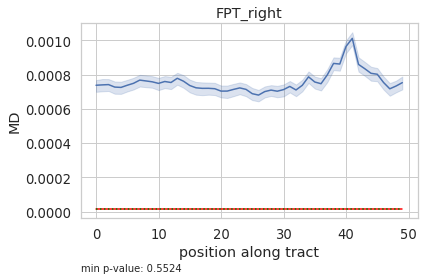

50 distance_map FA ST_PREF_right
alphaFWE : 0.0037302452740010277  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


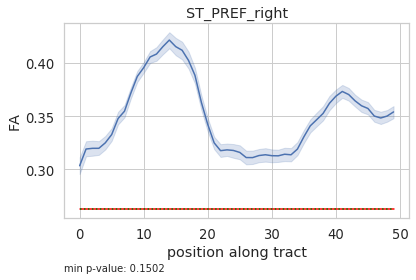

50 distance_map FA CC_2
alphaFWE : 0.0027663501349113303  clusterFWE : 8.0
Nb seg inf < 0.05 :  0.0


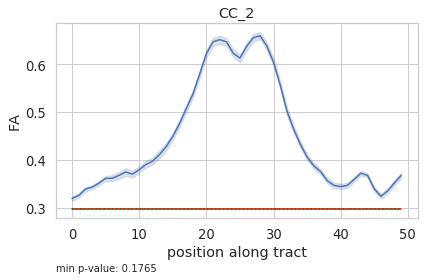

50 distance_map FA ST_FO_right
alphaFWE : 0.014273821799800726  clusterFWE : 13.0
Nb seg inf < 0.05 :  0.0


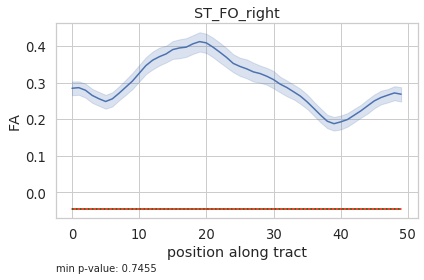

50 distance_map FA CC_1
alphaFWE : 0.011100517817438068  clusterFWE : 12.0
Nb seg inf < 0.05 :  0.0


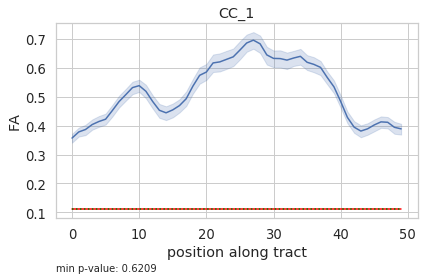

50 distance_map FA T_PREF_right
alphaFWE : 0.0028087787504377116  clusterFWE : 8.0
Nb seg inf < 0.05 :  0.0


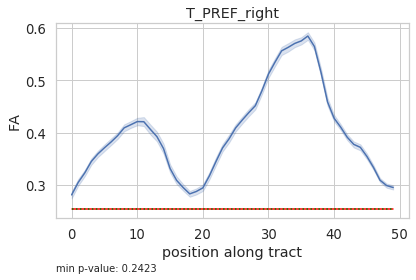

50 distance_map FA CG_right
alphaFWE : 0.003918568340319199  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


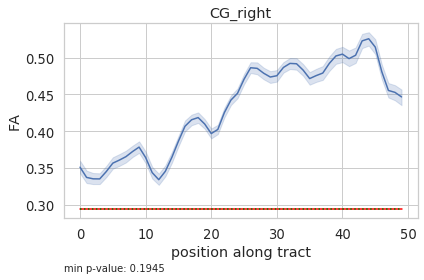

50 distance_map FA FPT_right
alphaFWE : 0.006302772348931949  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


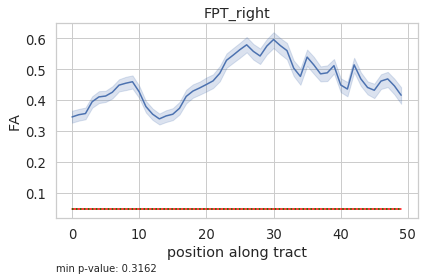

50 distance_map MD ST_PREF_right
alphaFWE : 0.006350673910087471  clusterFWE : 12.0
Nb seg inf < 0.05 :  0.0


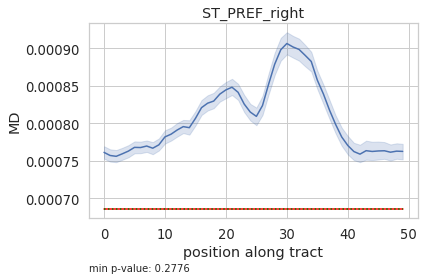

50 distance_map MD CC_2
alphaFWE : 0.005406191132327735  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


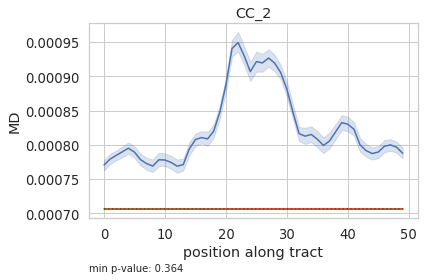

50 distance_map MD ST_FO_right
alphaFWE : 0.02301825058859385  clusterFWE : 14.0
Nb seg inf < 0.05 :  0.0


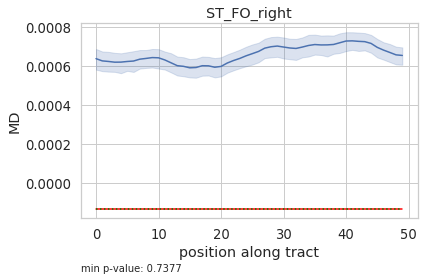

50 distance_map MD CC_1
alphaFWE : 0.016136222175111813  clusterFWE : 16.0
Nb seg inf < 0.05 :  0.0


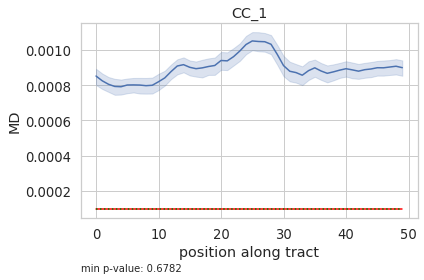

50 distance_map MD T_PREF_right
alphaFWE : 0.004510677503226335  clusterFWE : 11.0
Nb seg inf < 0.05 :  0.0


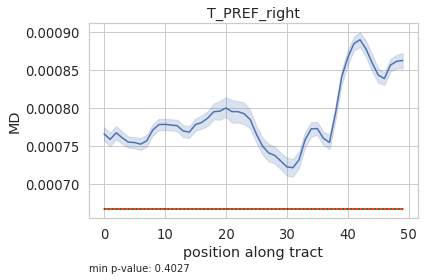

50 distance_map MD CG_right
alphaFWE : 0.005012858960601841  clusterFWE : 9.0
Nb seg inf < 0.05 :  0.0


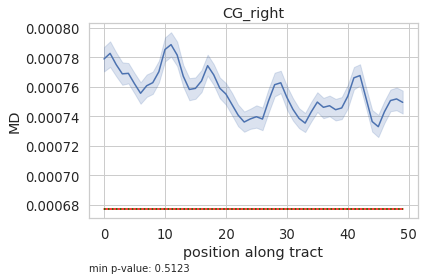

50 distance_map MD FPT_right
alphaFWE : 0.013004842191698235  clusterFWE : 10.0
Nb seg inf < 0.05 :  0.0


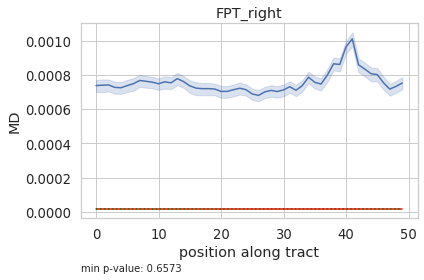

In [246]:
df = pd.read_csv(os.path.join(TRACTO_DIR,'Tractometry_template_4Correlation.txt'), sep=" ", comment="#")
df["subject_id"] = df["subject_id"].astype(str)

for ZSCORE in (["FE_Z_ScoreMoyen","Att_Z_ScoreMoyen","ME_Z_ScoreMoyen","FV_Z_ScoreMoyen","Lan_Z_ScoreMoyen"]):
    for NR_POINTS in ([50]):#([60,70,80,100]):
        for ALGORITHM in (['''distance_map''']):#(['''equal_dist''','''distance_map''','''cutting_plane''','''afq''']):
            for PARA in (['''FA''','''MD''']): 
                for BUNDLE in (['''ST_PREF_right''','''CC_2''','''ST_FO_right''','''CC_1''','''T_PREF_right''','''CG_right''','''FPT_right''']):    
                    print(NR_POINTS,ALGORITHM,PARA,BUNDLE)
                    if os.path.exists(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+'.npy')) :
                        npvalues=np.load(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+'.npy'))
                    else :  
                        npvalues = np.zeros([len(df),NR_POINTS])
                        for idx, jdx in df.iterrows():
                            SUBJ=df.iloc[idx]['subject_id'] # df.subject_id[0] ou encore jdx['subject_id']
                            #print(SUBJ)
                            TRACTO_TCK=os.path.join(TRACTO_DIR,SUBJ,'CT_'+BUNDLE+'_track.tck')
                            SCALAR_IMG=os.path.join(TRACTO_DIR,SUBJ,'fit_'+PARA+'.nii.gz')
                            START_IMG=os.path.join(TRACTO_DIR,SUBJ,'CT_ROI_'+SUBJ+'.nii.gz')
                            scalar_image = nib.load(SCALAR_IMG)
                            beginnings = nib.load(START_IMG)
                            sl_file = nib.streamlines.load(TRACTO_TCK)
                            streamlines = sl_file.streamlines
                            val=list(length(streamlines))
                            #print(np.mean(val),np.std(val))
                            if len(streamlines) > 5 :
                                mean, std = tractometry.evaluate_along_streamlines(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=2,predicted_peaks=None, affine=scalar_image.affine)
                                npvalues[idx, :] = mean[1:-1]
                        np.save(os.path.join(STUDY_PATH,PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)),npvalues)


                    ###########
                    #regression des covariables
                    ###########
                    confound=df[list(df.columns[2:6])].values
                    lr = LinearRegression(fit_intercept=True).fit(confound,npvalues) 
                    y_predicted_by_confound = lr.coef_ @ confound.T
                    npvalues_corrected = npvalues - y_predicted_by_confound.T

                    #Bring data into right format for seaborn
                    data = {"position": [],
                            "metric": [],
                            "group": [],
                            "subject": [],
                            "sex": []}

                    for idx, jdx in df.iterrows():
                        SUBJ=df.iloc[idx]['subject_id'] 
                        GROUP=df.iloc[idx]['group']                     
                        SEX=df.iloc[idx]['sex']
                        for position in range(NR_POINTS):
                            data["position"].append(position)
                            data["subject"].append(SUBJ)
                            data["metric"].append(npvalues_corrected[idx][position])
                            data["group"].append('G'+str(GROUP+1))
                            data["sex"].append(SEX)

                    pvalues = np.zeros(NR_POINTS)
                    stats = np.zeros(NR_POINTS)  # for ttest: t-value, for pearson: correlation
                    #stats, pvalues=scipy.stats.f_oneway(npvalues_corrected[df[df['group']==0].index,:], npvalues_corrected[df[df['group']==1].index,:], npvalues_corrected[df[df['group']==2].index,:], npvalues_corrected[df[df['group']==3].index,:])
                    for jdx in range(NR_POINTS):
                        stats[jdx], pvalues[jdx] = scipy.stats.pearsonr(npvalues_corrected[:,jdx], df[ZSCORE].values)
                    alpha=0.05
                    nperm=5000
                    alphaFWE, statFWE, clusterFWE, stats = AFQ_MultiCompCorrection(npvalues_corrected,df['group'].values,alpha, nperm=nperm)
                    print('alphaFWE :',alphaFWE,' clusterFWE :',clusterFWE)
                    pvalues_tmp=1-pvalues
                    pvalues_tmp[pvalues_tmp>0.95]=1
                    pvalues_tmp[pvalues_tmp<=0.95]=0
                    print("Nb seg inf < 0.05 : ",np.sum(pvalues_tmp))

                    #clusterFWE=NR_POINTS/10-1
                    #alphaFWE=0.05
                    #print('alphaFWE :',alphaFWE,' clusterFWE :',clusterFWE)   

                    sns.set(font_scale=1.2)
                    sns.set_style("whitegrid")
                    %matplotlib inline
                    #palette = sns.color_palette("mako_r", 6)
                    #color="coral"
                    #sns.set_palette("husl")
                    #dataTest = pd.Series(result_prices)
                    #penses betes palette=['0.3','0.3','0.6','0.3'] pour n
                    #ax = sns.lineplot(x="position", y="metric", palette=[ColorTab[0],ColorTab[1],ColorTab[2],ColorTab[3]],data=data,hue="group")
                    ax = sns.lineplot(x="position", y="metric", palette=ColorDic,data=data)
                    ax.set(xlabel='position along tract', ylabel=PARA)
                    ax.set_title(BUNDLE)        

                    sig_areas = get_significant_areas(pvalues, 1, alphaFWE)
                    sig_areas = sig_areas * np.quantile(np.array(data["metric"]), 0.98)
                    sig_areas[sig_areas == 0] = np.quantile(np.array(data["metric"]), 0.02)
                    ax.plot(range(len(sig_areas)), sig_areas, color="red", linestyle="-")
                    #clusterFWE=4
                    sig_areas2 = get_significant_areas(pvalues, clusterFWE, alpha)
                    sig_areas2 = sig_areas2 * np.quantile(np.array(data["metric"]), 0.98)
                    sig_areas2[sig_areas2 == 0] = np.quantile(np.array(data["metric"]), 0.02)
                    ax.plot(range(len(sig_areas2)), sig_areas2, color="green", linestyle=":")

                   # ax.annotate("alphaFWE:   {}".format(format_number(alphaFWE)),
                   #                  (0, 0), (0, -65), xycoords='axes fraction', textcoords='offset points', va='top',
                   #                  fontsize=10)
                    ax.annotate("min p-value: {}".format(format_number(pvalues.min())),
                                     (0, 0), (0, -45), xycoords='axes fraction', textcoords='offset points', va='top',
                                     fontsize=10)
                   # ax.annotate("clusterFWE:   {}".format(clusterFWE),
                   #                  (0, 0), (0, -55), xycoords='axes fraction', textcoords='offset points', va='top',
                   #                  fontsize=10)

                    plt.tight_layout()
                    plt.savefig(os.path.join(STUDY_PATH,"screenshots","CORR_"+ZSCORE+"_PROFILE_"+PARA+"_"+BUNDLE+"_"+ALGORITHM+"_"+str(NR_POINTS)+"_wcofound_clusterandfwe.png"), dpi=300)
                    plt.show()
                    plt.close()

In [104]:
#df[['group','subject_id']]
print(df.iloc[2]['group'])
print(df.iloc[2])
print(list(df))
print(df['age'][2])
filter1=df['group']==0
filter2=df['sex']==0
subdf=df.where(filter1&filter2,inplace=False)
subdf=subdf.dropna()
print(subdf['age'])
print(subdf['age'].mean())
#np.savetxt(os.path.join(TRACTO_DIR,'values_corr.txt'),npvalues_corrected.T)
#np.savetxt(os.path.join(TRACTO_DIR,'values.txt'),npvalues.T)


3
subject_id    640524MB240413
group                      3
center                     1
sex                        0
age                       49
education                 10
Name: 2, dtype: object
['subject_id', 'group', 'center', 'sex', 'age', 'education']
49
71    71.0
72    70.0
73    64.0
74    45.0
80    57.0
88    71.0
89    58.0
97    51.0
Name: age, dtype: float64
60.875
